# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v1-4a.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v1-4a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch
1  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch
2  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch
3  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch
4  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
28460  train/fr\fr_f_77c6a\fr_f_77c6a__rmx__lp6000.00...      french   
63103  train/es\es_m_b5327\es_m_b5327__rmx__lp6000.00...     spanish   
21402  train/en\en_m_29119\en_m_29119__rmx__lp6000.00...     english   
34094  train/fr\fr_m_3c5d7\fr_m_3c5d7__rmx__lp6000.00...      french   
24007  train/en\en_m_68767\en_m_68767__rmx__lp6000.00...     english   
60235  train/es\es_m_4d7e5\es_m_4d7e5__rmx__lp6000.00...     spanish   
18252  train/en\en_f_c8835\en_f_c8835__rmx__lp6000.00...     english   
3510   train/de\de_f_8e8ed\de_f_8e8ed__rmx__lp6000.00...      deutch   
35965  train/fr\fr_m_59472\fr_m_59472__rmx__lp6000.00...      french   
45927  train/pt\pt_m_01434\pt_m_01434__rmx__lp6000.00...  portuguese   
56462  train/es\es_f_bf428\es_f_bf428__rmx__lp6000.00...     spanish   
26851  train/fr\fr_f_20123\fr_f_20123__rmx__lp6000.00...      french   
45038  train/pt\pt_f_f587a\pt_f_f587a__rmx__lp6000.00...  portuguese   
16329  train/en\en_f_5dff2\en_f_5dff2__rmx__lp6000.00...     english   
1405   train/de\de_f_26ddc\de_f_26ddc__rmx__lp6000.00...      deutch   
35029  train/fr\fr_m_46787\fr_m_46787__rmx__lp6000.00...      french   
12459  train/de\de_m_df90b\de_m_df90b__rmx__lp6000.00...      deutch   
62102  train/es\es_m_7e1c8\es_m_7e1c8__rmx__lp6000.00...     spanish   
27144  train/fr\fr_f_4a5d2\fr_f_4a5d2__rmx__lp6000.00...      french   
34849  train/fr\fr_m_46787\fr_m_46787__rmx__lp6000.00...      french   
62482  train/es\es_m_9d824\es_m_9d824__rmx__lp6000.00...     spanish   
39494  train/pt\pt_f_11c7d\pt_f_11c7d__rmx__lp6000.00...  portuguese   
41776  train/pt\pt_f_5d3e4\pt_f_5d3e4__rmx__lp6000.00...  portuguese   
7274   train/de\de_m_1b27e\de_m_1b27e__rmx__lp6000.00...      deutch   
34252  train/fr\fr_m_42fc7\fr_m_42fc7__rmx__lp6000.00...      french   
49927  train/pt\pt_m_6e1fd\pt_m_6e1fd__rmx__lp6000.00...  portuguese   
40186  train/pt\pt_f_2c5e0\pt_f_2c5e0__rmx__lp6000.00...  portuguese   
4893   train/de\de_f_bce24\de_f_bce24__rmx__lp6000.00...      deutch   
17310  train/en\en_f_9a47e\en_f_9a47e__rmx__lp6000.00...     english   
40367  train/pt\pt_f_37eb7\pt_f_37eb7__rmx__lp6000.00...  portuguese   
2996   train/de\de_f_6cc5c\de_f_6cc5c__rmx__lp6000.00...      deutch   
61752  train/es\es_m_7e1c8\es_m_7e1c8__rmx__lp6000.00...     spanish   
32757  train/fr\fr_m_238c7\fr_m_238c7__rmx__lp6000.00...      french   
35024  train/fr\fr_m_46787\fr_m_46787__rmx__lp6000.00...      french   
26817  train/fr\fr_f_20123\fr_f_20123__rmx__lp6000.00...      french   
7394   train/de\de_m_1b27e\de_m_1b27e__rmx__lp6000.00...      deutch   
34534  train/fr\fr_m_42fc7\fr_m_42fc7__rmx__lp6000.00...      french   
59780  train/es\es_m_406bb\es_m_406bb__rmx__lp6000.00...     spanish   
11679  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...      deutch   
56018  train/es\es_f_bac9b\es_f_bac9b__rmx__lp6000.00...     spanish   

       sample_rate                                        time_series  \
28460        16000  [265, -238, -571, -493, -519, -930, -394, -713...   
63103        16000  [-1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, -1, 0, -2, ...   
21402        16000  [59, 81, 81, 107, 143, 169, 188, 218, 205, 205...   
34094        16000  [-146, -120, -107, -77, -31, 25, 80, 100, 116,...   
24007        16000  [-4110, -3583, -1639, 1056, 4329, 7334, 8056, ...   
60235        16000  [-281, -436, -518, -404, -404, -445, -451, -38...   
18252        16000  [-3011, -595, 1514, 2613, 3315, -2968, -6997, ...   
3510         16000  [-72, -724, -1647, -2314, -2930, -3638, -4272,...   
35965        16000  [-146, -117, 3, 213, 186, -36, -86, -27, 96, 2...   
45927        16000  [167, 259, -147, 129, 260, 79, 102, 285, -52, ...   
56462        16000  [2524, 345, -1663, -3376, -4900, -6275, -7392,...   
26851        16000  [2047, 2619, 3038, 3385, 3676, 3777, 3739, 355...   
45038        16000  [1109888, 20183296, 37736576, 46191872, 407916...   
16329        16000  [-10226, -9240, -7895, -6377, -4797, -3116, -1...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
1  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
2  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
3  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
4  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_0809f__rmx__lp6000.           None           None  ambiance            
1  de_f_0809f__rmx__lp6000.           None           None  ambiance            
2  de_f_0809f__rmx__lp6000.           None           None  ambiance            
3  de_f_0809f__rmx__lp6000.           None           None  ambiance            
4  de_f_0809f__rmx__lp6000.           None           None  ambiance            

   augmented_data  
0            True  
1            True  
2            True  
3            True  
4            True

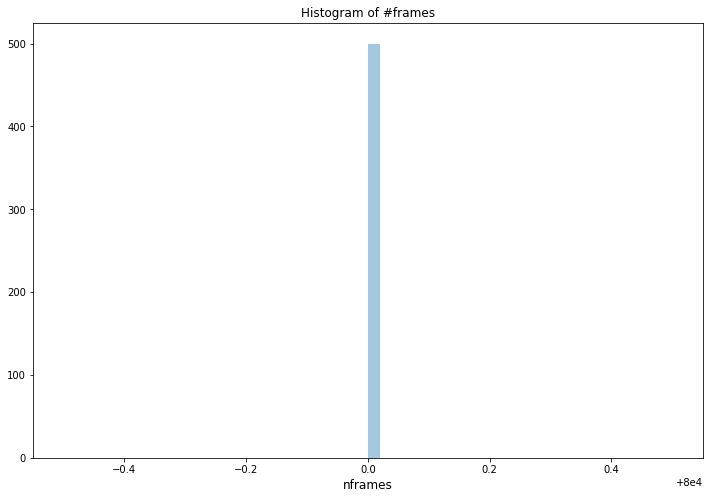

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

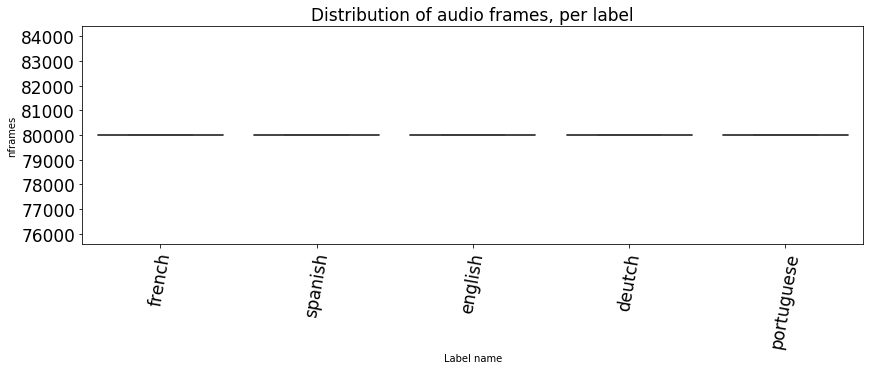

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0     train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
8726  train/de\de_m_4d099\de_m_4d099__rmx__lp6000.00...  deutch   
8727  train/de\de_m_4d099\de_m_4d099__rmx__lp6000.00...  deutch   
8728  train/de\de_m_4d099\de_m_4d099__rmx__lp6000.00...  deutch   
8729  train/de\de_m_4d099\de_m_4d099__rmx__lp6000.00...  deutch   

                     file_name speed_changing pitch_changing noise_add  \
0     de_f_0809f__rmx__lp6000.           None           None  ambiance   
8726  de_m_4d099__rmx__lp6000.           0.80           None      None   
8727  de_m_4d099__rmx__lp6000.           0.80           None      None   
8728  de_m_4d099__rmx__lp6000.           0.80           None      None   
8729  de_m_4d099__rmx__lp6000.           0.80           None      None   

     low_pass  augmented_data  
0                        True  
8726                     True  
8727                     True  
8728                     True  
8729                     True

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

13098

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


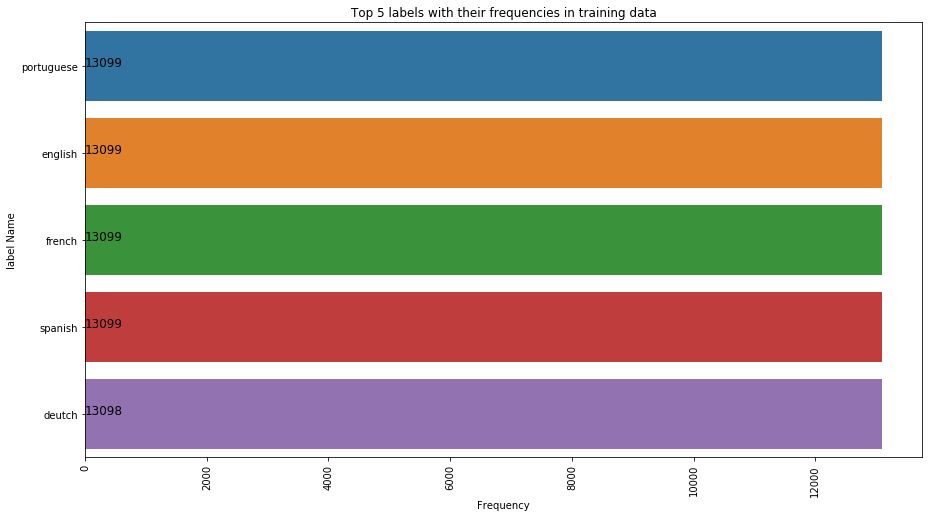

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                28
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__lp6000.    486
       de_f_1996a__rmx__lp6000.    466
       de_f_26ddc__rmx__lp6000.    489
       de_f_2825f__rmx__lp6000.    468
       de_f_40479__rmx__lp6000.    446

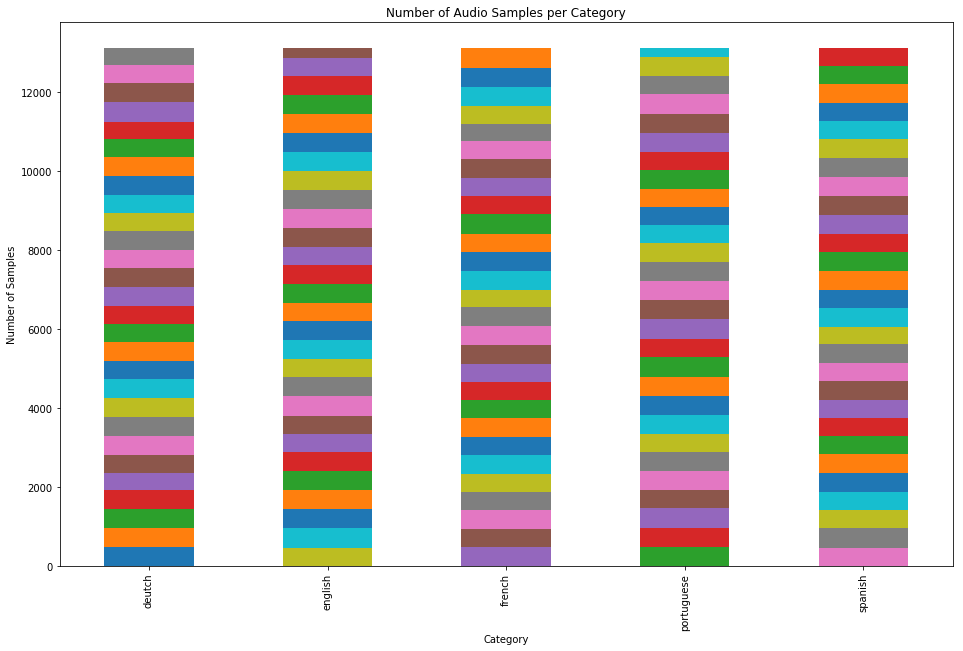

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f        6588
           m        6510
english    f        6663
           m        6436
french     f        6547
           m        6552
portuguese f        6242
           m        6857
spanish    f        6523
           m        6576

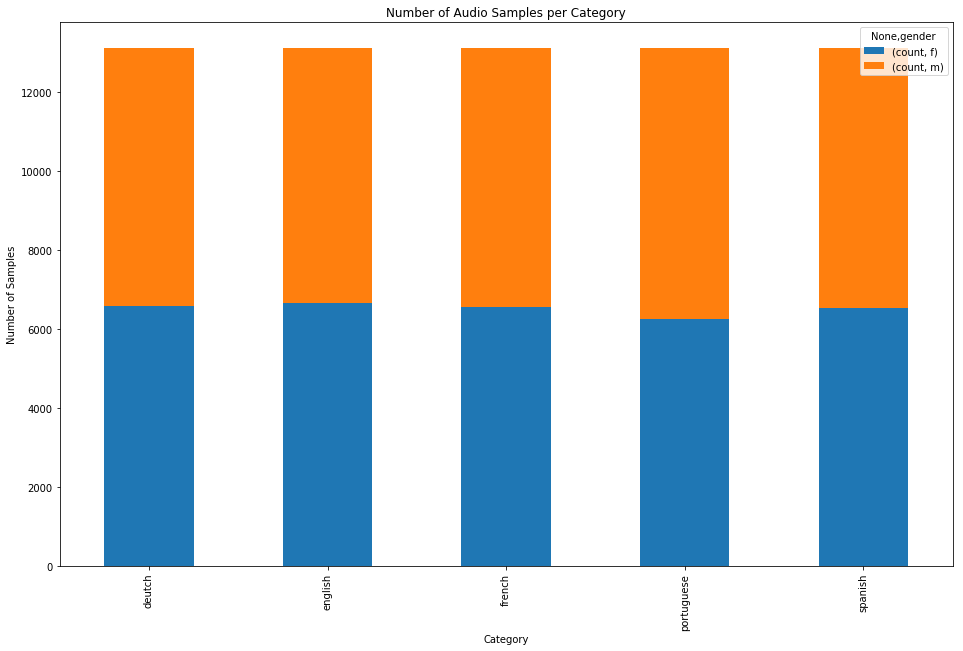

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     True            13098
english    True            13099
french     True            13099
portuguese True            13099
spanish    True            13099

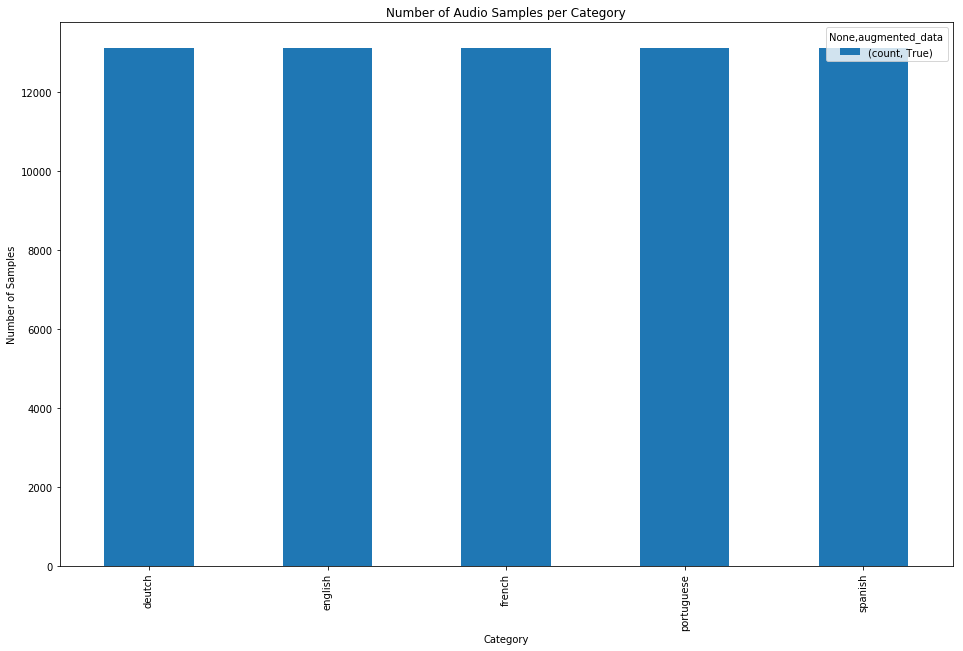

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
deutch     True            13098            5060            4960       2479   
english    True            13099            4949            5023       2520   
french     True            13099            5052            4952       2476   
portuguese True            13099            4966            4996       2528   
spanish    True            13099            5049            4968       2484   

                           low_pass  
label      augmented_data            
deutch     True               13098  
english    True               13099  
french     True               13099  
portuguese True               13099  
spanish    True               13099

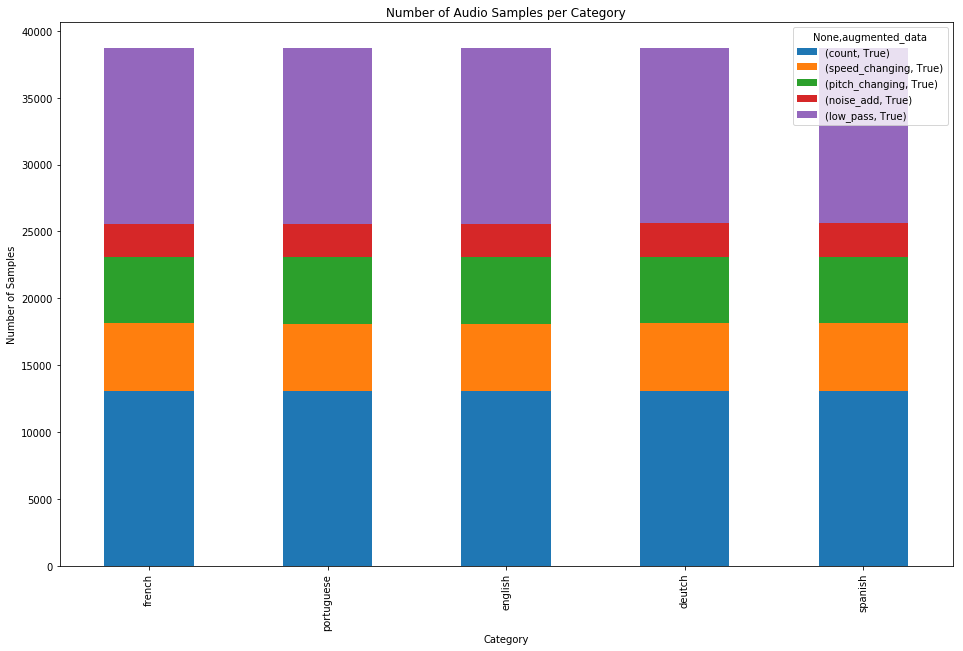

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

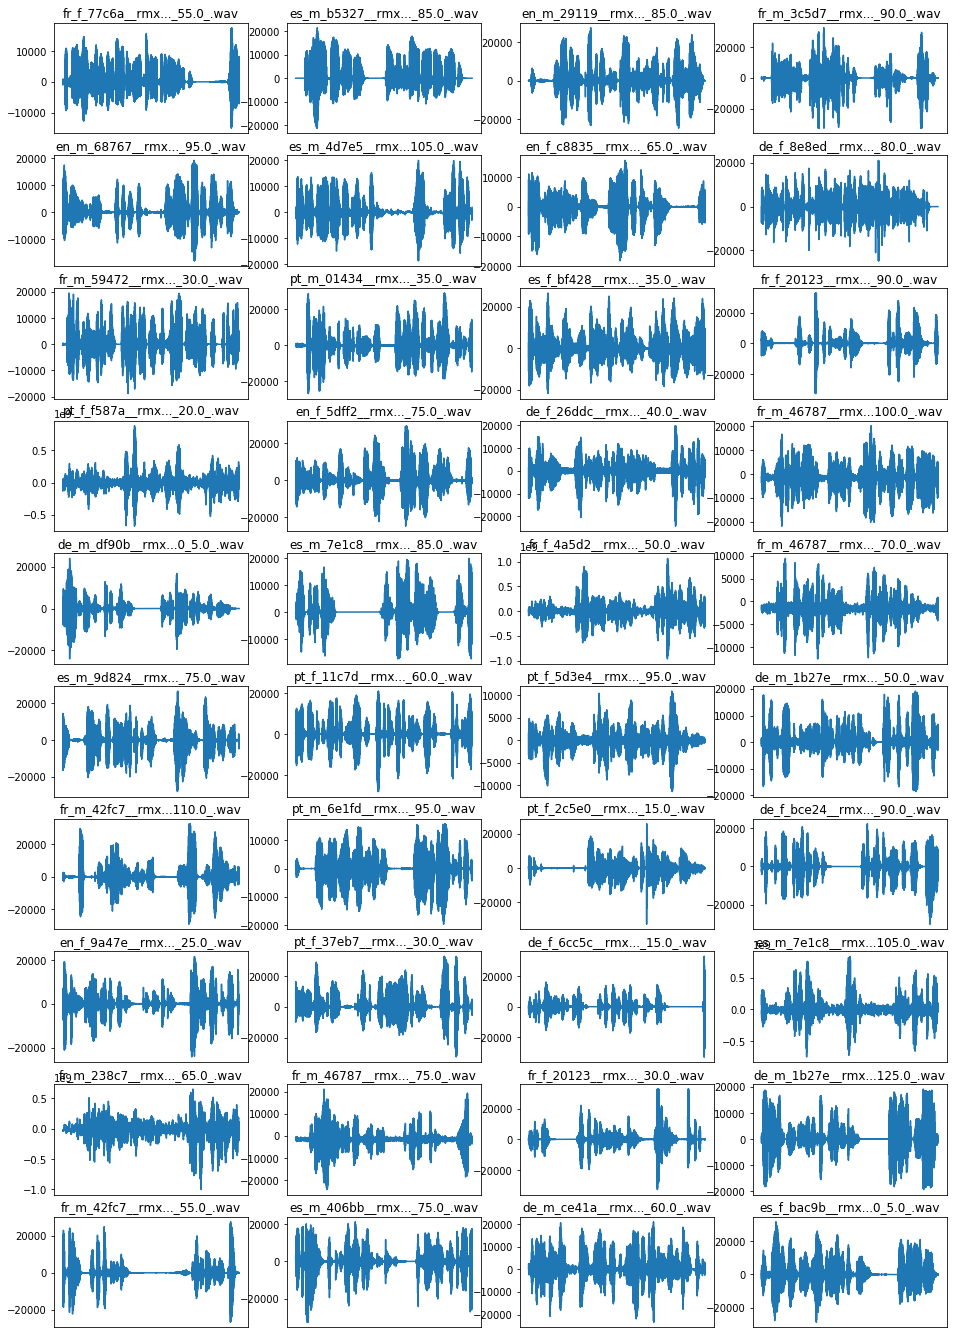

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

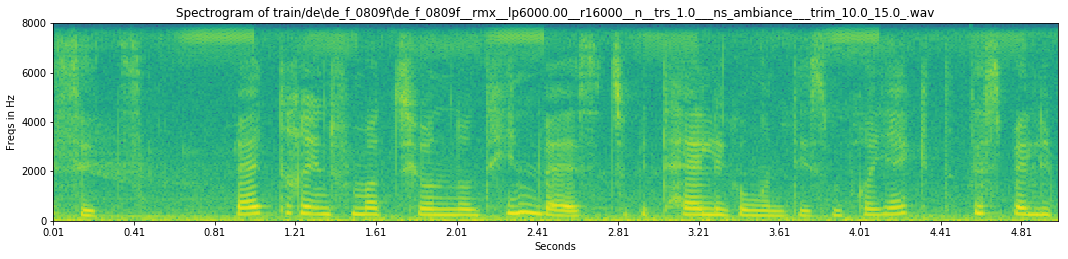

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (65494, 9)


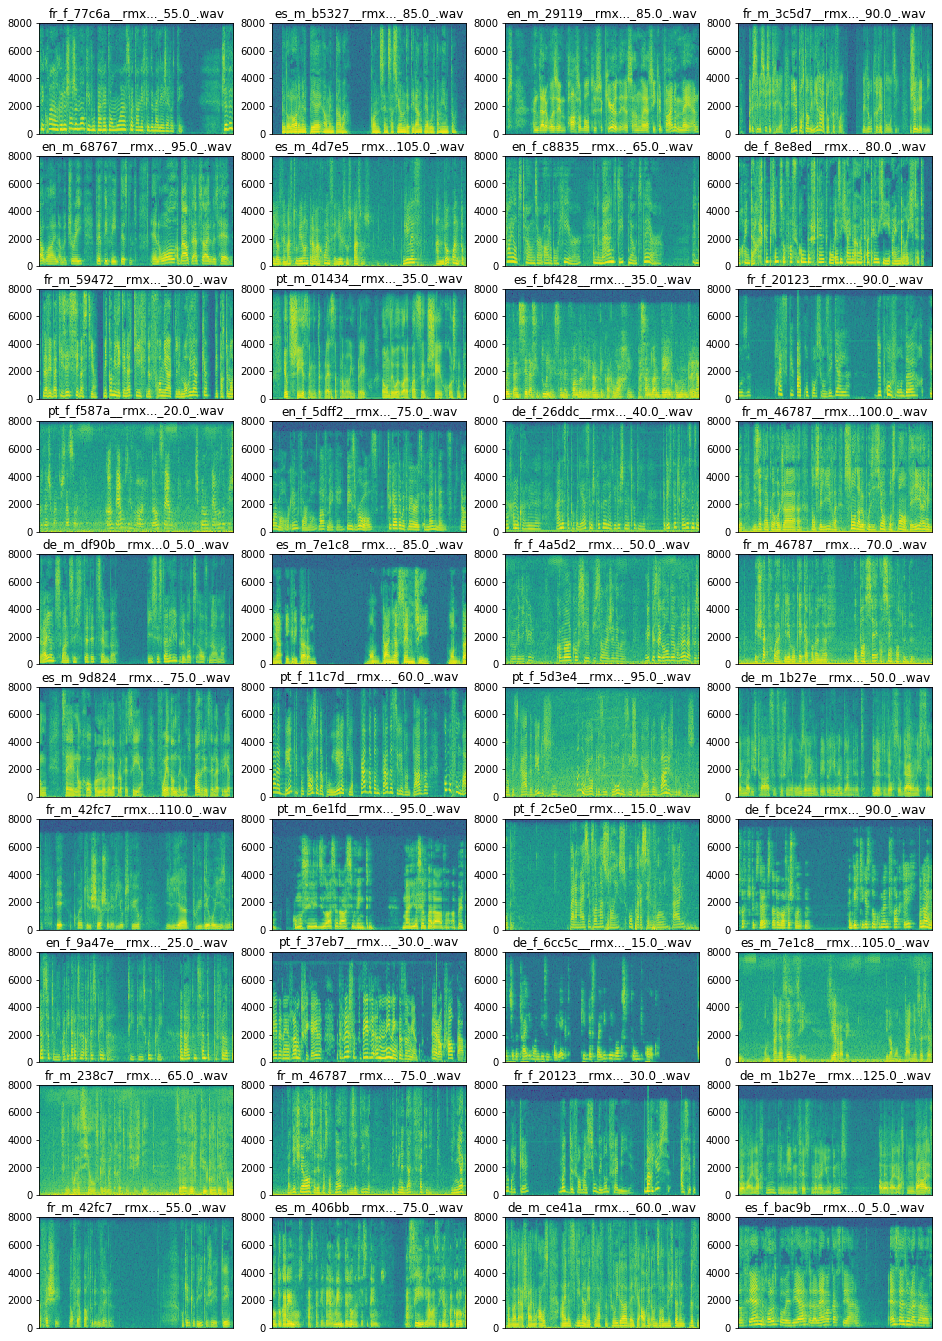

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

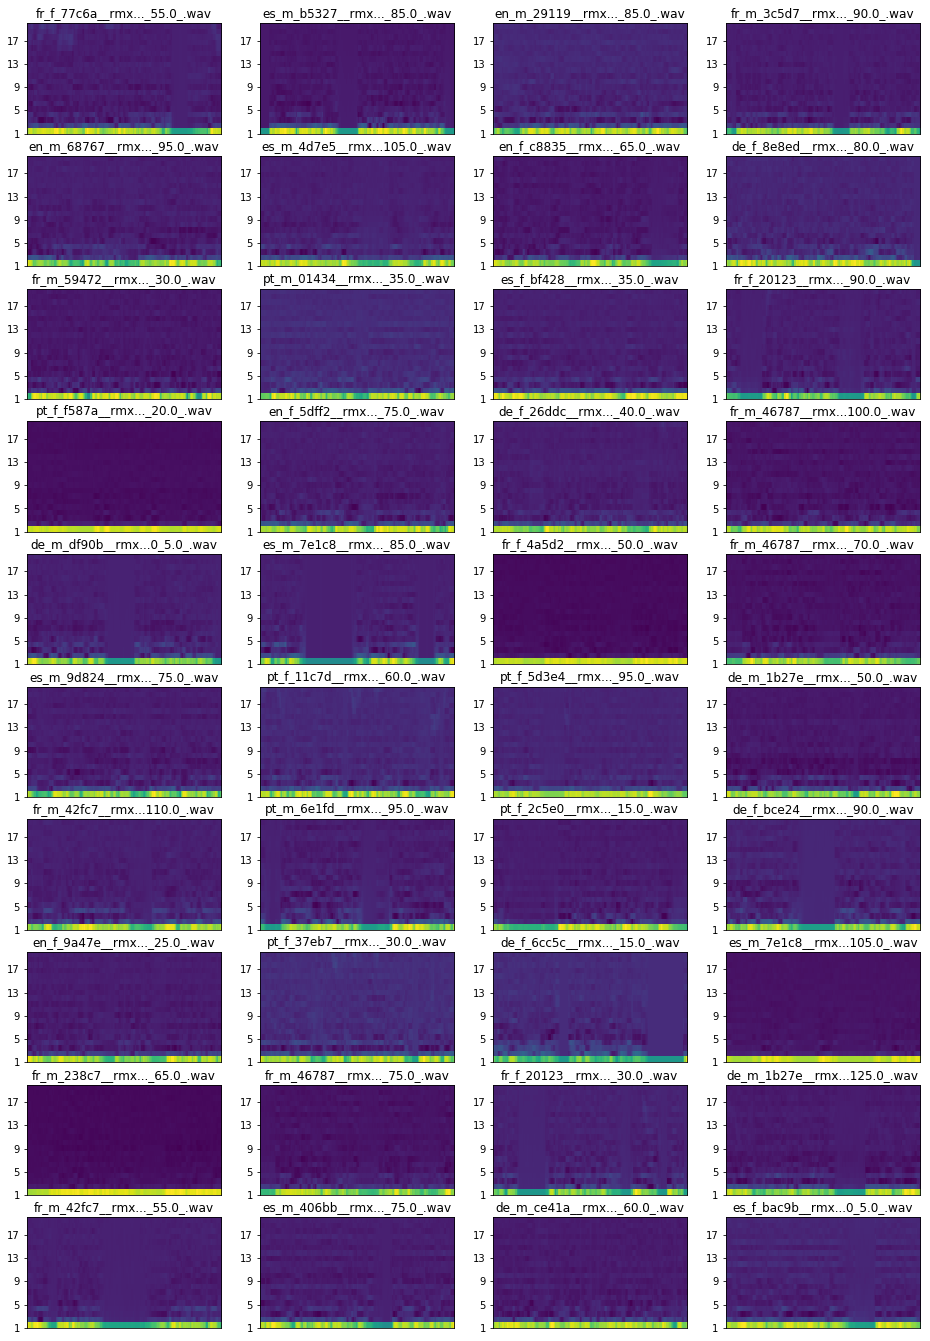

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

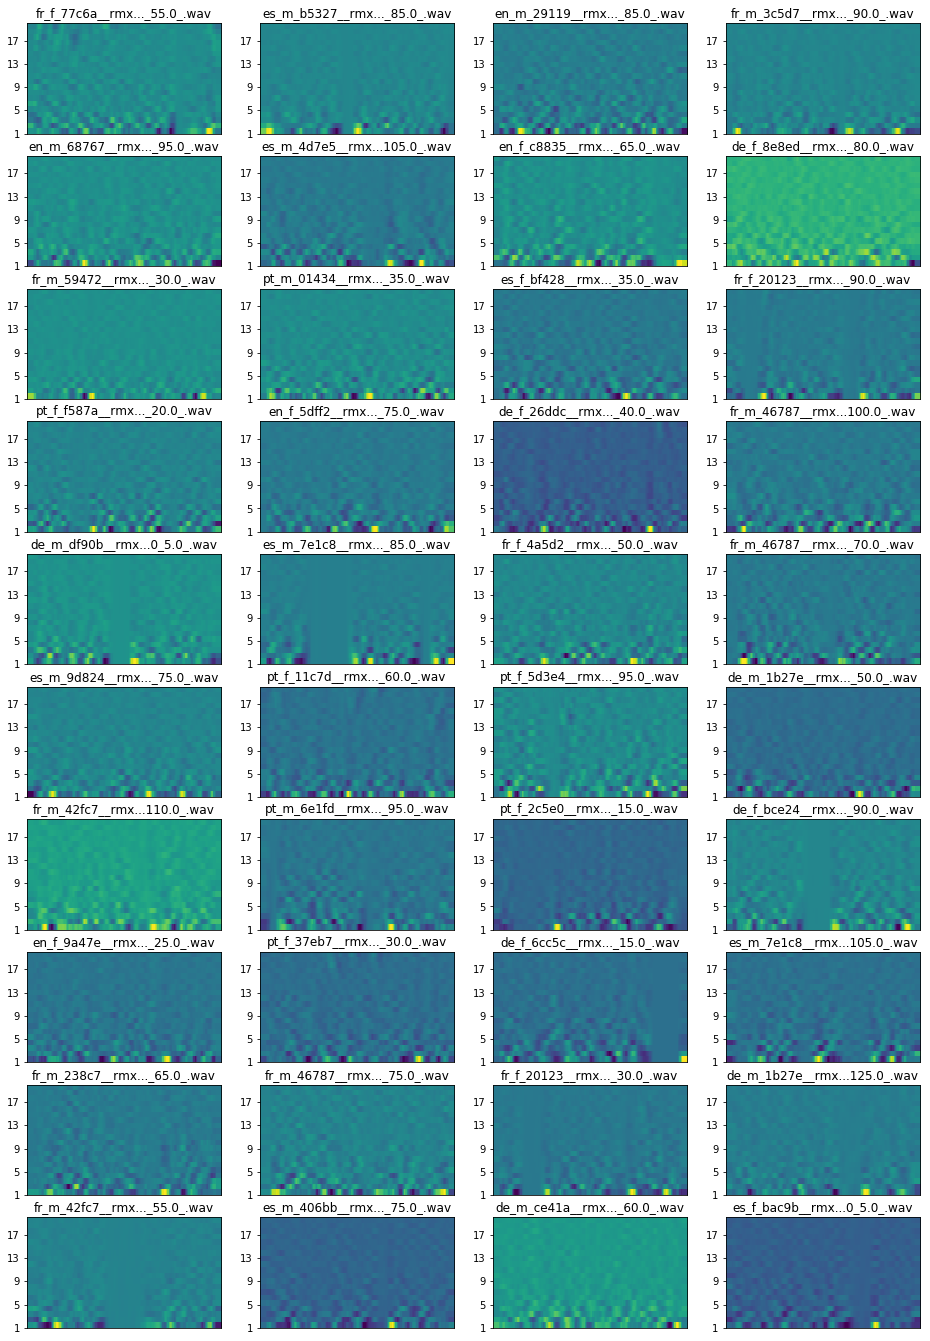

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

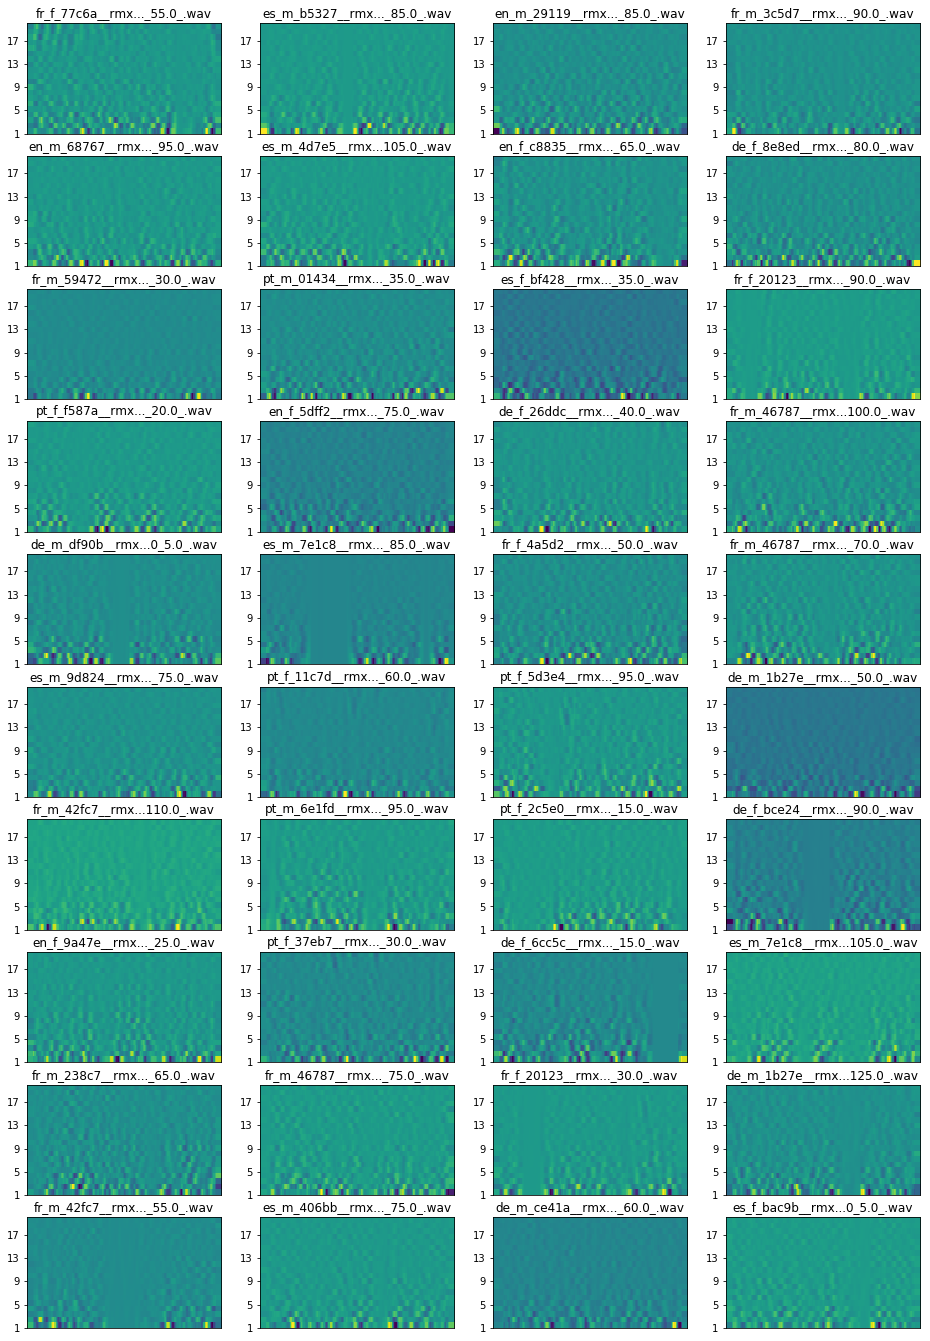

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

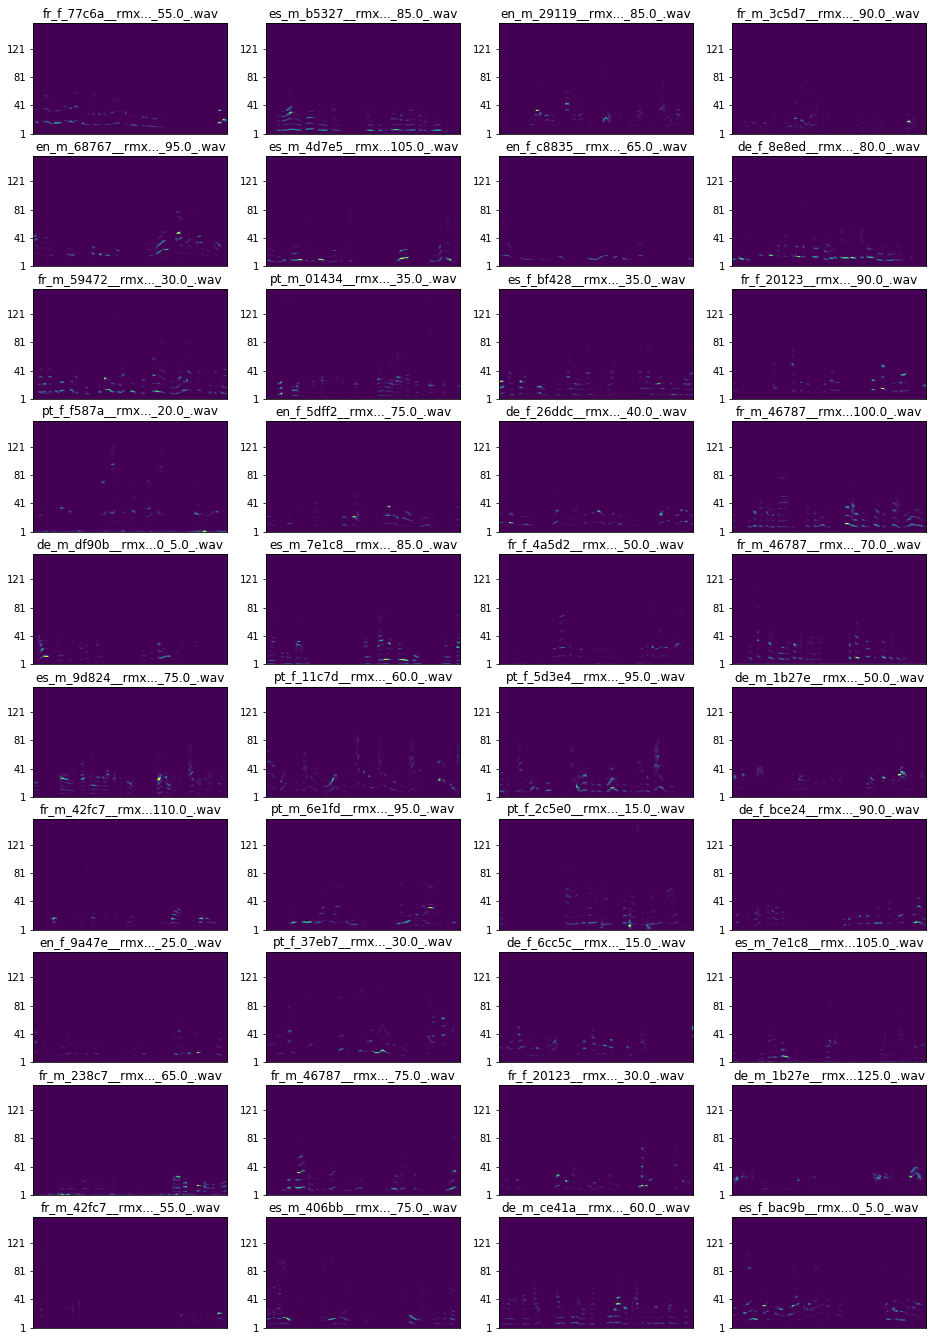

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  